In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import ase.io
from time import time
from copy import deepcopy

from aml_storage import Labels, Block, Descriptor

from utils.librascal import RascalSphericalExpansion
from utils.clebsh_gordan import ClebschGordanReal

This example demonstrates the iterative construction of atom-centered density correlations.
The calculations incorporate ideas from the N-body iterative contraction of equivariants [paper](https://doi.org/10.1063/5.0021116) and the optimal radial basis [paper](https://doi.org/10.1063/5.0057229).

# Covariance-optimal basis

We start by computing the spherical expansion representation for a set of methane structures. 

In [11]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 5,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  True,
}

nmax, lmax = rascal_hypers["max_radial"], rascal_hypers["max_angular"]
calculator = RascalSphericalExpansion(rascal_hypers)

In [35]:
frames = ase.io.read("./data/random-methane-10k.extxyz", "::100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [36]:
density_expansion = calculator.compute(frames)

Then, select the C,H block, which is the most significant for this dataset, and project to the optimal covariance basis.

In [37]:
# for each (C,H) block, construct the optimal covariance basis
opt_eve = {}
opt_eva = {}
full_norms = np.zeros(len(frames))
for index, block in density_expansion:
    if index["center_species"] == 6 and index["neighbor_species"] == 1:
        feats = block.values.reshape(-1, len(block.features))
        full_norms += (block.values**2).sum(axis=-1).sum(axis=-1)
        cov = feats.T @ feats / feats.shape[0]
        eva, eve = sp.linalg.eigh(cov)
        eva = eva[::-1]; eve = eve[:,::-1]
        opt_eva[index["spherical_harmonics_l"]] = eva
        opt_eve[index["spherical_harmonics_l"]] = eve

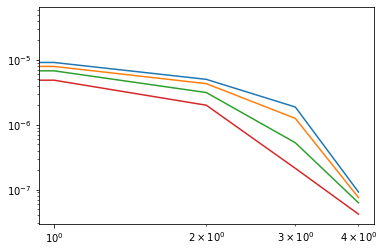

In [38]:
for l in range(lmax+1):
    plt.loglog(opt_eva[l])

Create compressed features, using labels naming consistent with Nigam 2020

In [39]:
sel_thresh = 1e-6
blocks = []
for l in range(lmax+1):
    n_selected = len(np.where(opt_eva[l] > sel_thresh)[0])    
    de_block = density_expansion.block(center_species = 6, neighbor_species=1, spherical_harmonics_l = l)
    block = Block(
        data = de_block.values@opt_eve[l][:,:n_selected],
        samples = de_block.samples,
        components = Labels(["m"],np.asarray(range(-l,l+1), dtype=np.int32).reshape(-1,1)),
        features = Labels(["n"], np.asarray([[n] for n in range(n_selected)], dtype=np.int32))
    )
    if rascal_hypers["compute_gradients"]:
        de_grad = de_block.gradient("positions")
        block.add_gradient(
            name="positions",
            samples=de_grad[0],
            gradient=de_grad[1]@opt_eve[l][:,:n_selected],
        )
    blocks.append( block )

In [40]:
acdc_nu1 = Descriptor(sparse = Labels(names=["sigma", "lam", "nu"], 
                                      values=np.asarray([[ 1, l, 1] for l in range(rascal_hypers["max_angular"]+1)], dtype=np.int32)), 
                      blocks = blocks
                     )

In [41]:
# multiplicity of the features, stored as a descriptor array
acdc_full_nu1 = Descriptor(
    sparse = acdc_nu1.sparse,
    blocks = [
        Block(
            data = np.ones(shape=(1,1,len(acdc_nu1.block(s).features))),
            samples = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            components = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            features = acdc_nu1.block(s).features
        ) for s in acdc_nu1.sparse
    ]
)

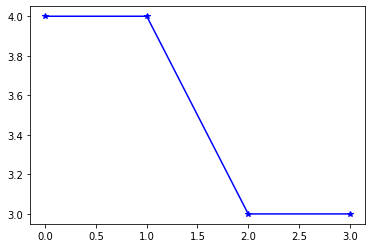

In [42]:
ln_nu1 = np.asarray([[s["lam"], b.values.shape[-1]] for s,b in acdc_nu1 ])
plt.plot(ln_nu1[:,0], ln_nu1[:,1], 'b*-')

# ACDC utilities

In [43]:
def _mdesc_2_mdict(mdesc):
    """ Converts a descriptors of weights to a dictionary """
    mdict = {}
    for index, block in mdesc:                
        mdict[tuple(index)] = { tuple(f):w for f,w in zip(block.features, block.values[0,0]) }   
    return mdict
def _mdict_2_mdesc(mdict, sparse_names, feature_names):
    """ Converts a dictionary of weights to a descriptor """
    return Descriptor(
        sparse=Labels(names=sparse_names, values=np.asarray(list(mdict.keys()), dtype=np.int32) ),
        blocks = [
            Block(
                data = np.asarray(list(b.values())).reshape(1,1,-1),
                components = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32) ),
                samples = Labels(["dummy"],  np.zeros(shape=(1,1), dtype=np.int32)),
                features = Labels(feature_names, np.asarray(list(b.keys()), dtype=np.int32) )   
            ) for b in mdict.values()
        ]
    )

In [44]:
def acdc_full_product_indices(m_a, m_b, feature_names=None):
    """
    Enumerates the indices of features that result from a product of ACDC equivariants.
    Sparse indices should be labeled as ("sigma", "lam", "nu"). 
    The arguments should correspond to the list of feature weights (multiplicities), to
    account for selection and duplicate removal. 
    """
    
    # determines the cutoff in the new features
    lmaw_a = max(m_a.sparse["lam"])
    lmaw_b = max(m_b.sparse["lam"])
    lcut = lmaw_a+lmaw_b+1
    
    # assumes uniform nu
    nu_a = m_a.sparse["nu"][0]
    nu_b = m_b.sparse["nu"][0]
    
    # block indexes for the incremented features
    NU=nu_a+nu_b    
    M_dict = {(S, L, NU):{} for L in range(lcut+1) for S in [-1,1]}

    # automatic generation of the output features names - "x1 x2 x3 ; x1 x2 -> x1_a x2_a x3_a k_nu x1_b x2_b l_nu"
    if feature_names is None:
        feature_names = tuple( n+"_a" for n in m_a.block(0).features.names) + ("k_"+str(NU),) + tuple( n+"_b" for n in m_b.block(0).features.names ) + ("l_"+str(NU),) 
    
    # computes the indices that must be present, as well as their weights
    for index_a, block_a in m_a:
        lam_a = index_a["lam"]        
        sigma_a = index_a["sigma"]
        for index_b, block_b in m_b:
            lam_b = index_b["lam"]
            sigma_b = index_b["sigma"]
            for f_a, w_a in zip(block_a.features, block_a.values[0,0]):
                f_a = tuple(f_a)                
                for f_b, w_b in zip(block_b.features, block_b.values[0,0]):
                    f_b = tuple(f_b)
                    W = w_a*w_b
                    IDX = f_a+(lam_a,)+f_b+(lam_b,)
                    for L in range(np.abs(lam_a-lam_b), 1+min(lam_a+lam_b, lcut) ):
                        S = sigma_a*sigma_b*(-1)**(lam_a+lam_b+L)
                        M_dict[(S,L,NU)][IDX] = W

    # removes empty blocks
    for k in list(M_dict):
        if len(M_dict[k]) ==0:
            M_dict.pop(k)

    # casts the weights into a Descriptor format
    return _mdict_2_mdesc(M_dict, m_a.sparse.names, feature_names)

In [45]:
aa=0
def acdc_combine(x_a, m_a, x_b, m_b, M=None, feature_names=None, clebsch_gordan=None):
    """
    Performs a CG product of two sets of equivariants. Only requirement is that 
    sparse indices are labeled as ("sigma", "lam", "nu"). The automatically-determined
    naming of output features can be overridden by giving a list of "feature_names".
    A dictionary of select_features (organized in the same blocks as the sparse indices,
    each containing a dictionary of the feature indices and an associated multiplicity)
    can also be specified to filter the features that should be selected. 
    """
    global aa
    # determines the cutoff in the new features
    lmax_a = max(x_a.sparse["lam"])
    lmax_b = max(x_b.sparse["lam"])
    lcut = lmax_a+lmax_b
    start = time()
    # creates a CG object, if needed
    if clebsch_gordan is None:
        clebsch_gordan = ClebschGordanReal(lcut)
    
    # assumes uniform nu in the descriptors
    nu_a = x_a.sparse["nu"][0]
    nu_b = x_b.sparse["nu"][0]
    
    # block indexes for the incremented features
    NU=nu_a+nu_b    
    X_blocks = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    X_idx = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    
    #NB : assumes the samples are matching. we could add some kind of validation, at least on size if not on content
    samples = x_a.block(0).samples
    nsamples = len(samples)
    try:
        grad_samples, _ = x_a.block(0).gradient("positions")
        X_grads = {(S, L, NU): [] for L in range(lcut+1) for S in [-1,1]}
    except:
        grad_samples = None
    
    # automatic generation of the output features names - "x1 x2 x3 ; x1 x2 -> x1_a x2_a x3_a k_nu x1_b x2_b l_nu"
    if feature_names is None:
        feature_names = tuple( n+"_a" for n in x_a.block(0).features.names) + ("k_"+str(NU),) +tuple( n+"_b" for n in x_b.block(0).features.names ) + ("l_"+str(NU),) 

    if M is None:
        M = acdc_full_product_indices(m_a, m_b)
        
    # it's much easier (and faster) to manipulate this as a dictionary of dictionaries
    M_dict = _mdesc_2_mdict(M)
    m_a_dict = _mdesc_2_mdict(m_a)
    m_b_dict = _mdesc_2_mdict(m_b)

    print("prep", time()-start)
    start = time()
    # loops over sparse blocks of x_a
    for index_a, block_a in x_a:
        lam_a = index_a["lam"]
        sigma_a = index_a["sigma"]
        w_block_a = m_a_dict[tuple(index_a)]
        # and x_b
        for index_b, block_b in x_b:
            lam_b = index_b["lam"]
            sigma_b = index_b["sigma"]
            w_block_b = m_b_dict[tuple(index_b)]
            #loops over all permissible output blocks. note that blocks will be filled from different la, lb
            for L in range(np.abs(lam_a-lam_b), 1+min(lam_a+lam_b, lcut) ):
                # determines parity of the block
                S = sigma_a*sigma_b*(-1)**(lam_a+lam_b+L)
                W_block = M_dict[(S,L,NU)]
                sel_feats = []
                sel_weights = []                
                #determines the features that are in the select list
                for n_a in range(len(block_a.features)):
                    f_a = tuple(block_a.features[n_a])
                    w_a = w_block_a[f_a]
                    for n_b in range(len(block_b.features)):                    
                        f_b = tuple(block_b.features[n_b])
                        w_b = w_block_b[f_b]
                        
                        # the index is assembled consistently with the scheme above
                        IDX = f_a + (lam_a,) + f_b + (lam_b,)                        
                        if IDX in W_block:
                            w_X = W_block[IDX]
                        else:                            
                            continue
                        sel_feats.append([n_a,n_b])
                        sel_weights.append(np.sqrt(w_X/(w_a*w_b)))
                        X_idx[(S,L,NU)].append(IDX)
                    
                sel_feats = np.asarray(sel_feats, dtype=int)
                
                if len(sel_feats) == 0:
                    continue

                # builds all products in one go
                one_shot_blocks = clebsch_gordan.combine_einsum(block_a.values[:,:,sel_feats[:,0]],
                                                         block_b.values[:,:,sel_feats[:,1]],
                                                         L, combination_string="iq,iq->iq" )
                # do gradients, if they are present...
                if grad_samples is not None:
                    smp_a, grad_a = block_a.gradient("positions")
                    smp_b, grad_b = block_b.gradient("positions")
                    one_shot_grads = ( clebsch_gordan.combine_einsum(
                                        block_a.values[smp_a['sample']][:,:,sel_feats[:,0]],
                                        grad_b[:,:,sel_feats[:,1]],
                                        L=L,combination_string="iq,iq->iq") +
                                    clebsch_gordan.combine_einsum(
                                        block_b.values[smp_b['sample']][:,:,sel_feats[:,1]],
                                        grad_a[:,:,sel_feats[:,0]],
                                        L=L,combination_string="iq,iq->iq")
                        )
                
                # now loop over the selected features to build the blocks
                for Q in range(len(sel_feats)):
                    #(n_a, n_b) = sel_feats[Q]
                    newblock = one_shot_blocks[:,:,Q]*sel_weights[Q]                    
                    X_blocks[(S,L,NU)].append(newblock)
                    if grad_samples is not None:
                        newgrad = one_shot_grads[:,:,Q]*sel_weights[Q]
                        X_grads[(S,L,NU)].append(newgrad)                        

    print("calc", time()-start)
    start = time()
    # turns data into sparse storage format (and dumps any empty block in the process)
    nz_idx = []
    nz_blk = []
    for SLN in X_blocks:
        S, L, NU = SLN
        # create blocks
        if (len(X_blocks[SLN])==0): continue  # skips empty blocks
        nz_idx.append(SLN)
        newblock= Block(
                        # feature index must be last
                        data=np.moveaxis(np.asarray(X_blocks[SLN]), 0, -1),
                        samples = samples,
                        components = Labels(["mu"],np.asarray(range(-L,L+1), dtype=np.int32).reshape(-1,1)),
                        features = Labels( feature_names,
                                           np.asarray(X_idx[SLN],dtype=np.int32)
                                          )
                          ) 
        if grad_samples is not None:
            newblock.add_gradient("positions", grad_samples, np.moveaxis(np.asarray(X_grads[SLN]), 0, -1))
        nz_blk.append(newblock)
    X = Descriptor(Labels(["sigma", "lam", "nu"], np.asarray(nz_idx, dtype=np.int32)), nz_blk)
    print("clean", time()-start)
    return X, M

In [46]:
x2 = acdc_combine(acdc_nu1, acdc_full_nu1, acdc_nu1, acdc_full_nu1)

prep 0.28843259811401367
calc 0.7087311744689941
clean 0.023537397384643555


In [47]:
def acdc_increment(x_nu, m_nu, x_1, m_1, M=None, clebsch_gordan=None):
    """ Specialized version of the CG product to perform iterations with nu=1 features"""
    nu = x_nu.sparse["nu"][0]
    if nu==1:
        feature_names = ("n_1", "l_1", "n_2", "l_2")
    else:
        feature_names = tuple(x_nu.block(0).features.names) + ("k_"+str(nu+1), "n_"+str(nu+1),"l_"+str(nu+1))
    return acdc_combine(x_nu, m_nu, x_1, m_1, feature_names = feature_names, M = M, clebsch_gordan=clebsch_gordan)

In [48]:
cg = ClebschGordanReal(lmax*3)

In [49]:
%%time
acdc_nu2, acdc_full_nu2 = acdc_increment(acdc_nu1, acdc_full_nu1, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg)

prep 0.04297208786010742
calc 0.3694770336151123
clean 0.02672290802001953
CPU times: user 598 ms, sys: 247 ms, total: 845 ms
Wall time: 442 ms


In [27]:
%%time
acdc_nu3, acdc_full_nu3 = acdc_increment(acdc_nu2, acdc_full_nu2, acdc_nu1, acdc_full_nu1, clebsch_gordan = cg)

prep 0.44214558601379395
calc 3.454162836074829
clean 0.464646577835083
CPU times: user 3.89 s, sys: 499 ms, total: 4.38 s
Wall time: 4.38 s


## analyze jacobian

Requires `compute_gradients=True`

manually densify features

In [19]:
j_nu1 = []
for idx, block in acdc_nu1:
    smp, grad = block.gradient("positions")
    j_nu1.append(grad.reshape((grad.shape[0],-1)))
j_nu1 = np.concatenate(j_nu1, axis=-1).reshape(10,12,-1)    

In [20]:
j_nu2 = []
for idx, block in acdc_nu2:
    smp, grad = block.gradient("positions")
    j_nu2.append(grad.reshape((grad.shape[0],-1)))
j_nu2 = np.concatenate(j_nu2, axis=-1).reshape(10,12,-1)

In [21]:
j_nu3 = []
for idx, block in acdc_nu3:
    smp, grad = block.gradient("positions")
    j_nu3.append(grad.reshape((grad.shape[0],-1)))
j_nu3 = np.concatenate(j_nu3, axis=-1).reshape(10,12,-1)

sv_nu3 = np.asarray([ sp.linalg.svdvals(j_nu3[i])  for i in range(10)])

In [22]:
import scipy as sp

In [23]:
sv_nu1 = np.asarray([ sp.linalg.svdvals(j_nu1[i])  for i in range(10)])
sv_nu2 = np.asarray([ sp.linalg.svdvals(j_nu2[i])  for i in range(10)])

Text(0, 0.5, 'CN ($\\nu=2)$')

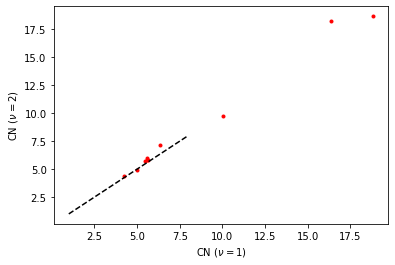

In [24]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu2[:,0]/sv_nu2[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=2)$")

Text(0, 0.5, 'CN ($\\nu=3)$')

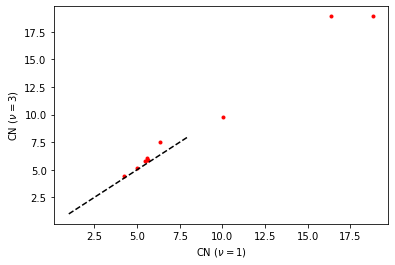

In [25]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu3[:,0]/sv_nu3[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=3)$")

# Independent feature tracking

This performs the cg iteration while avoiding to compute duplicate / linearly dependent features, and tracks the multiplicity so that no density (correlation) is lost

In [28]:
def _get_idx_nl(nu, idx, names):  
    # extracts the n,l feature indices. assumes indices are labelled n_nu, l_nu
    nl_values = np.zeros((nu,2), dtype = np.int32)    
    for i, n in enumerate(names):
        w, k = n.split("_")
        k = int(k)
        if w == "n":
            nl_values[k-1][0] = idx[i]
        elif w == "l":
            nl_values[k-1][1] = idx[i]
    return nl_values

def _sort_idx_nl(nl_values):
    # sorts the n,l indices lexicographically (l first, then n)
    isort = np.lexsort(nl_values.T)
    return nl_values[isort]

In [29]:
def acdc_canonical_indices(m_nu, m_1, M = None):
    """ Determines canonical (n,l, lexicographically sorted) indices, to 
    implement the selection rule with lam_1<l2<l3 ... lam_nu [cf. Nigam et al. JCP 2020]
    This eliminates a large fraction of the linearly dependent equivariants. 
    NB: this only works if we keep stacking the same density coefficients, which we assume are 
    passed as the second argument.
    Also tracks multiplicity so norm should be conserved. """
    
    nu = m_nu.sparse["nu"][0]
    if nu==1:
        names = ("n_1", "l_1", "n_2", "l_2")
    else:
        names = tuple(m_nu.block(0).features.names) + ("k_"+str(nu+1), "n_"+str(nu+1),"l_"+str(nu+1))
    if M is None:
        M = acdc_full_product_indices(m_nu, m_1)
    
    M_dict = {}
    for m_index, m_block in M:
        canonical_idx = {}
        canonical_counts = {}
        if len(m_block.features) == 0:
            continue    
        for idx, W in zip(m_block.features, m_block.values[0,0]):
            idx = tuple(idx)
            # gets only the n,l part of the nu features 
            cidx = _get_idx_nl(nu+1, idx, names)
            # gets the sorted version
            sidx = _sort_idx_nl(cidx)
            # converts to tuple
            cidx = tuple(cidx.flatten())
            sidx = tuple(sidx.flatten())
            # gets multiplicity (weight)            
                
            if not sidx in canonical_counts:
                canonical_idx[sidx] = []
                canonical_counts[sidx] = 0
            
            canonical_counts[sidx] += W
            if cidx == sidx:
                canonical_idx[sidx].append(idx)
            
        MD = {}
        for nl in canonical_counts:            
            if (canonical_counts[nl]%len(canonical_idx[nl]) !=0):
                    print("non integer count!", canonical_counts[nl], len(canonical_idx[nl]))                
            for idx in canonical_idx[nl]:
                MD[idx] = canonical_counts[nl]/len(canonical_idx[nl])        
        M_dict[tuple(m_index)] = MD
    
    # casts the weights into a Descriptor format
    return _mdict_2_mdesc(M_dict, M.sparse.names, names)

In [28]:
cg = ClebschGordanReal(lmax*5)

In [29]:
norm_full1 = 0.0
for i, b in acdc_nu1:
    norm_full1 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [30]:
acdc_sel_nu2 = acdc_canonical_indices(acdc_full_nu1, acdc_full_nu1)

In [31]:
%%time
canonical_acdc_nu2, _ = acdc_increment(acdc_nu1, acdc_full_nu1, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg, M=acdc_sel_nu2)

prep 0.004172325134277344
calc 0.10399413108825684
clean 0.006589651107788086
CPU times: user 115 ms, sys: 3.16 ms, total: 118 ms
Wall time: 116 ms


In [32]:
acdc_sel_nu3 = acdc_canonical_indices(acdc_sel_nu2, acdc_full_nu1)

In [33]:
%%time
canonical_acdc_nu3, _ = acdc_increment(canonical_acdc_nu2, acdc_sel_nu2, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu3)

prep 0.021066904067993164
calc 1.0295162200927734
clean 0.018707990646362305
CPU times: user 1.08 s, sys: 4.59 ms, total: 1.08 s
Wall time: 1.07 s


In [34]:
acdc_sel_nu4 = acdc_canonical_indices(acdc_sel_nu3, acdc_full_nu1)

In [35]:
canonical_acdc_nu4, _ = acdc_increment(canonical_acdc_nu3, acdc_sel_nu3, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu4)

prep 0.27839207649230957
calc 16.354865074157715
clean 0.3044583797454834


In [36]:
acdc_sel_nu5 = acdc_canonical_indices(acdc_sel_nu4, acdc_full_nu1)

In [37]:
canonical_acdc_nu5, _ = acdc_increment(canonical_acdc_nu4, acdc_sel_nu4, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu5)

prep 3.353417158126831
calc 1146.0874655246735
clean 49.27133846282959


compute norms and show that they match the norm of nu=1 features to the power nu

In [38]:
nnu2_full = np.sum([ len(b.features) for i, b in acdc_nu2 ])
nnu2_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu2 ])

In [39]:
norm_full2 = 0.0
for i, b in acdc_nu2:
    norm_full2 += (b.values**2).sum(axis=-1).sum(axis=-1)
norm_can2 = 0.0
for i, b in canonical_acdc_nu2:
    norm_can2 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [40]:
print((nnu2_full, norm_full2.sum()), (nnu2_can, norm_can2.sum()), (norm_full1**2).sum())

(307, 8.757907717288745e-07) (174, 8.757907717288746e-07) 8.75790771728875e-07


In [41]:
nnu3_full = np.sum([ len(b.features) for i, b in acdc_nu3 ])
nnu3_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu3 ])

In [42]:
norm_full3 = 0.0
for i, b in acdc_nu3:
    norm_full3 += (b.values**2).sum(axis=-1).sum(axis=-1)
norm_can3 = 0.0
for i, b in canonical_acdc_nu3:
    norm_can3 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [43]:
print((nnu3_full, norm_full3.sum()), (nnu3_can, norm_can3.sum()),(norm_full1**3).sum())

(10349, 3.15323670990659e-10) (2380, 3.1532367099065907e-10) 3.1532367099065933e-10


In [44]:
nnu4_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu4 ])

In [45]:
norm_can4 = 0.0
for i, b in canonical_acdc_nu4:
    norm_can4 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [46]:
print((nnu4_can, norm_can4.sum()),(norm_full1**4).sum())

(28799, 1.2927915921857593e-13) 1.292791592185761e-13


In [47]:
nnu5_can = np.sum([ len(b.features) for i, b in canonical_acdc_nu5 ])

In [48]:
norm_can5 = 0.0
for i, b in canonical_acdc_nu5:
    norm_can5 += (b.values**2).sum(axis=-1).sum(axis=-1)

In [49]:
print((nnu5_can, norm_can5.sum()),(norm_full1**5).sum())

(315159, 5.88423254342501e-17) 5.884232543425024e-17


# Iterative scheme

In [50]:
acdc_nu2, acdc_full_nu2 = acdc_increment(acdc_nu1, acdc_full_nu1, acdc_nu1, acdc_full_nu1, clebsch_gordan=cg)

prep 0.017388105392456055
calc 0.30941176414489746
clean 0.019566059112548828


In [51]:
acdc_nu2.block(0).features

Labels([(0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 2, 0), (0, 0, 3, 0),
        (1, 0, 0, 0), (1, 0, 1, 0), (1, 0, 2, 0), (1, 0, 3, 0),
        (2, 0, 0, 0), (2, 0, 1, 0), (2, 0, 2, 0), (2, 0, 3, 0),
        (3, 0, 0, 0), (3, 0, 1, 0), (3, 0, 2, 0), (3, 0, 3, 0),
        (0, 1, 0, 1), (0, 1, 1, 1), (0, 1, 2, 1), (0, 1, 3, 1),
        (1, 1, 0, 1), (1, 1, 1, 1), (1, 1, 2, 1), (1, 1, 3, 1),
        (2, 1, 0, 1), (2, 1, 1, 1), (2, 1, 2, 1), (2, 1, 3, 1),
        (3, 1, 0, 1), (3, 1, 1, 1), (3, 1, 2, 1), (3, 1, 3, 1),
        (0, 2, 0, 2), (0, 2, 1, 2), (0, 2, 2, 2), (1, 2, 0, 2),
        (1, 2, 1, 2), (1, 2, 2, 2), (2, 2, 0, 2), (2, 2, 1, 2),
        (2, 2, 2, 2), (0, 3, 0, 3), (0, 3, 1, 3), (0, 3, 2, 3),
        (1, 3, 0, 3), (1, 3, 1, 3), (1, 3, 2, 3), (2, 3, 0, 3),
        (2, 3, 1, 3), (2, 3, 2, 3)],
       dtype=[('n_1', '<i4'), ('l_1', '<i4'), ('n_2', '<i4'), ('l_2', '<i4')])

In [52]:
X = acdc_nu2.block(0).values

In [53]:
rX = X.reshape(-1,X.shape[-1]) * 1

In [54]:
nrm = (rX**2).sum(axis=0)

In [55]:
nrm

array([2.42940970e-07, 4.45236273e-08, 2.46073523e-08, 1.03791992e-08,
       4.45236273e-08, 2.29396324e-08, 7.32309093e-09, 3.56362288e-09,
       2.46073523e-08, 7.32309093e-09, 9.12791720e-09, 1.38798002e-09,
       1.03791992e-08, 3.56362288e-09, 1.38798002e-09, 1.52720383e-09,
       6.08419466e-08, 1.12379404e-08, 5.15856091e-09, 1.39895330e-09,
       1.12379404e-08, 3.10903465e-08, 6.50486933e-09, 1.88331929e-09,
       5.15856091e-09, 6.50486933e-09, 1.33623268e-08, 3.27955986e-09,
       1.39895330e-09, 1.88331929e-09, 3.27955986e-09, 3.30279380e-09,
       5.33147404e-08, 8.50633090e-09, 4.30948222e-09, 8.50633090e-09,
       3.52817376e-08, 7.90600428e-09, 4.30948222e-09, 7.90600428e-09,
       9.88785826e-09, 7.96731127e-08, 8.35800052e-09, 3.48786496e-09,
       8.35800052e-09, 2.28591699e-08, 2.75720216e-09, 3.48786496e-09,
       2.75720216e-09, 5.14521614e-09])

In [56]:
sca = nrm*0+1

In [57]:
aidx = nrm.argmin()
aidx = 1
miv = rX[:,aidx]
print(aidx, nrm[aidx])

1 4.452362726594057e-08


In [58]:
rX = np.hstack([rX[:,:aidx], rX[:,aidx+1:]])
sca = np.concatenate([sca[:aidx], sca[aidx+1:]])
nrm = np.concatenate([nrm[:aidx], nrm[aidx+1:]])

In [61]:
prj/nrm

array([-0.08901728, -0.13926044, -0.07885441,  1.        , -0.53846526,
        1.33084476,  0.9576714 , -0.13926044,  1.33084476, -0.66889759,
       -2.1800674 , -0.07885441,  0.9576714 , -2.1800674 , -2.87818224,
        0.19993843, -1.28327545, -0.9197659 ,  0.31047506, -1.28327545,
        0.16097781,  1.46285602, -0.03968666, -0.9197659 ,  1.46285602,
        0.77276911,  1.69168539,  0.31047506, -0.03968666,  1.69168539,
        1.96298614, -0.03850159, -1.11937661, -0.25807999, -1.11937661,
       -0.4205467 ,  1.8172761 , -0.25807999,  1.8172761 , -0.94371073,
        0.08471566, -1.51418101, -0.41761758, -1.51418101,  0.21588799,
        2.43859512, -0.41761758,  2.43859512,  1.18851966])

In [60]:
prj =miv@rX
sca += (prj/nrm)**2

In [62]:
sca

array([1.00792408, 1.01939347, 1.00621802, 2.        , 1.28994483,
       2.77114777, 1.91713451, 1.01939347, 2.77114777, 1.44742398,
       5.75269388, 1.00621802, 1.91713451, 5.75269388, 9.28393301,
       1.03997537, 2.64679589, 1.84596931, 1.09639476, 2.64679589,
       1.02591386, 3.13994773, 1.00157503, 1.84596931, 3.13994773,
       1.59717209, 3.86179945, 1.09639476, 1.00157503, 3.86179945,
       4.8533146 , 1.00148237, 2.25300398, 1.06660528, 2.25300398,
       1.17685953, 4.30249243, 1.06660528, 4.30249243, 1.89058994,
       1.00717674, 3.29274413, 1.17440445, 3.29274413, 1.04660762,
       6.94674618, 1.17440445, 6.94674618, 2.41257898])

In [63]:
(X.squeeze()@X.squeeze().T - rX@np.diag(sca)@rX.T ).diagonal().sum()

-3.5911273329198e-07

In [64]:
(X.squeeze()@X.squeeze().T - rX@rX.T ).diagonal().sum()

4.452362726594059e-08

In [65]:
nrm

array([2.42940970e-07, 2.46073523e-08, 1.03791992e-08, 4.45236273e-08,
       2.29396324e-08, 7.32309093e-09, 3.56362288e-09, 2.46073523e-08,
       7.32309093e-09, 9.12791720e-09, 1.38798002e-09, 1.03791992e-08,
       3.56362288e-09, 1.38798002e-09, 1.52720383e-09, 6.08419466e-08,
       1.12379404e-08, 5.15856091e-09, 1.39895330e-09, 1.12379404e-08,
       3.10903465e-08, 6.50486933e-09, 1.88331929e-09, 5.15856091e-09,
       6.50486933e-09, 1.33623268e-08, 3.27955986e-09, 1.39895330e-09,
       1.88331929e-09, 3.27955986e-09, 3.30279380e-09, 5.33147404e-08,
       8.50633090e-09, 4.30948222e-09, 8.50633090e-09, 3.52817376e-08,
       7.90600428e-09, 4.30948222e-09, 7.90600428e-09, 9.88785826e-09,
       7.96731127e-08, 8.35800052e-09, 3.48786496e-09, 8.35800052e-09,
       2.28591699e-08, 2.75720216e-09, 3.48786496e-09, 2.75720216e-09,
       5.14521614e-09])